# AWS AI Agent - Deployed Endpoint Demo

This notebook demonstrates the **complete user acceptance criteria** for the AWS AI Agent assessment.

## 📋 What This Notebook Demonstrates

1. ✅ **Cognito Authentication** - Creating users and obtaining JWT tokens
2. ✅ **AgentCore Invocation** - Using **HTTPS + Cognito JWT Bearer token**
3. ✅ **All 5 User Acceptance Queries** - Required assessment queries
4. ✅ **Langfuse Observability** - Automatic tracing of all executions
5. ✅ **LangGraph ReAct Agent** - Multi-step reasoning with tool use
6. ✅ **RAG with Bedrock KB** - Searching Amazon financial documents
7. ✅ **Stock Data Tools** - Real-time and historical queries via yfinance

## 🔧 Prerequisites

Before running this notebook:

1. **Deploy infrastructure**: Run `terraform apply` in the `terraform/` directory
2. **Upload documents**: Run `./scripts/upload_financial_documents.sh`
3. **Update configuration**: Set the correct values below from terraform outputs:
   - `COGNITO_USER_POOL_ID` - from `terraform output cognito_user_pool_id`
   - `COGNITO_APP_CLIENT_ID` - from `terraform output cognito_app_client_id`
   - `AGENTCORE_RUNTIME_ID` - from `terraform output agentcore_runtime_id`
4. **Configure AWS credentials**: Ensure AWS CLI is configured with valid credentials

## 📦 Required Python Packages

```bash
pip install boto3 requests
```

---

## Setup & Configuration

In [176]:
import boto3
import requests
import json
import uuid
import urllib.parse
from typing import Dict, Any
import time
from IPython.display import display, Markdown

# Deployment configuration - UPDATE THESE FROM TERRAFORM OUTPUTS
AWS_REGION = "us-east-2"
COGNITO_USER_POOL_ID = "us-east-2_FqySaFWQS"  # terraform output cognito_user_pool_id
COGNITO_APP_CLIENT_ID = "2dhmq9u19aho743foek2pvb15m"  # terraform output cognito_app_client_id
AGENTCORE_RUNTIME_ARN = "arn:aws:bedrock-agentcore:us-east-2:302703038631:runtime/dev_ai_agent_runtime-gyk2kqEYA6"  # terraform output agentcore_runtime_arn

# Construct AgentCore HTTPS endpoint
ESCAPED_ARN = urllib.parse.quote(AGENTCORE_RUNTIME_ARN, safe='')
AGENTCORE_ENDPOINT = f"https://bedrock-agentcore.{AWS_REGION}.amazonaws.com/runtimes/{ESCAPED_ARN}/invocations?qualifier=DEFAULT"

# Initialize boto3 client for Cognito
cognito_client = boto3.client('cognito-idp', region_name=AWS_REGION)

display(Markdown(
    f"**Configuration loaded**\n\n"
    f"| Setting | Value |\n"
    f"|---------|-------|\n"
    f"| Region | `{AWS_REGION}` |\n"
    f"| Cognito User Pool | `{COGNITO_USER_POOL_ID}` |\n"
    f"| Cognito App Client | `{COGNITO_APP_CLIENT_ID}` |\n"
    f"| AgentCore Runtime | `{AGENTCORE_RUNTIME_ARN.split('/')[-1]}` |\n"
))

**Configuration loaded**

| Setting | Value |
|---------|-------|
| Region | `us-east-2` |
| Cognito User Pool | `us-east-2_FqySaFWQS` |
| Cognito App Client | `2dhmq9u19aho743foek2pvb15m` |
| AgentCore Runtime | `dev_ai_agent_runtime-gyk2kqEYA6` |


## Cognito Authentication

### Step 1: Create Test User

In [168]:
def create_test_user(username: str = "test", password: str = "TestPassword123!", email: str = "test@example.com"):
    """Create a test user in Cognito user pool."""
    try:
        cognito_client.admin_create_user(
            UserPoolId=COGNITO_USER_POOL_ID,
            Username=username,
            UserAttributes=[
                {'Name': 'email', 'Value': email},
                {'Name': 'email_verified', 'Value': 'true'}
            ],
            MessageAction='SUPPRESS'
        )
        cognito_client.admin_set_user_password(
            UserPoolId=COGNITO_USER_POOL_ID,
            Username=username,
            Password=password,
            Permanent=True
        )
        display(Markdown(f"User **{username}** created successfully"))
        return True
    except cognito_client.exceptions.UsernameExistsException:
        display(Markdown(f"User **{username}** already exists (ready to use)"))
        return True
    except Exception as e:
        display(Markdown(f"**Error:** `{e}`"))
        return False

create_test_user()

User **test** already exists (ready to use)

True

### Step 2: Authenticate and Get JWT Token

**This JWT token will be used for AgentCore authorization via Bearer token.**

In [180]:
def authenticate(username: str = "test", password: str = "TestPassword123!") -> str:
    """Authenticate with Cognito and get JWT access token."""
    response = cognito_client.initiate_auth(
        ClientId=COGNITO_APP_CLIENT_ID,
        AuthFlow='USER_PASSWORD_AUTH',
        AuthParameters={'USERNAME': username, 'PASSWORD': password}
    )
    
    access_token = response['AuthenticationResult']['AccessToken']
    expires_in = response['AuthenticationResult']['ExpiresIn']
    
    display(Markdown(
        f"Authenticated as **{username}**\n\n"
        f"| Field | Value |\n"
        f"|-------|-------|\n"
        f"| Token type | `Bearer` |\n"
        f"| Expires in | {expires_in}s ({expires_in//60} min) |\n"
        f"| Token preview | `{access_token[:40]}...` |"
    ))
    return access_token

access_token = authenticate()

Authenticated as **test**

| Field | Value |
|-------|-------|
| Token type | `Bearer` |
| Expires in | 3600s (60 min) |
| Token preview | `eyJraWQiOiJ5V0p6YUV6UDVvQTU2d0k3Z2lOY0R4...` |

## AgentCore Invocation with Cognito JWT

This function invokes AgentCore via **HTTPS with Cognito JWT Bearer token**.

**Authentication Method:** OAuth (Cognito JWT) - matches AgentCore configuration

In [170]:
from IPython.display import display, Markdown, HTML

def query_agent(query: str, token: str, session_id: str = None, stream: bool = False) -> Dict[str, Any]:
    """Query the AI agent via AgentCore HTTPS endpoint with Cognito JWT."""
    if session_id is None:
        session_id = str(uuid.uuid4())

    mode = "Streaming" if stream else "Non-streaming"
    display(Markdown(f"---\n### Query\n> {query}\n\n`Session: {session_id}` | `Mode: {mode}`"))

    try:
        start = time.time()

        headers = {
            'Authorization': f'Bearer {token}',
            'Content-Type': 'application/json',
            'X-Session-Id': session_id
        }

        payload = {"query": query, "stream": stream}

        if stream:
            response = requests.post(
                AGENTCORE_ENDPOINT,
                headers=headers,
                json=payload,
                timeout=300,
                stream=True
            )

            if response.status_code != 200:
                error_msg = f"HTTP {response.status_code}: {response.text}"
                display(Markdown(f"**Error:** `{error_msg}`"))
                raise Exception(error_msg)

            elapsed_first = None
            full_answer = ""
            events = []
            tools_used = []

            print("Streaming response:\n")

            for line in response.iter_lines(decode_unicode=True):
                if elapsed_first is None:
                    elapsed_first = (time.time() - start) * 1000

                if line and line.startswith("data: "):
                    data_str = line[6:]
                    try:
                        event = json.loads(data_str)
                        events.append(event)
                        event_type = event.get("event_type", "unknown")
                        data = event.get("data", {})

                        if event_type == "tool_call":
                            tool_name = data.get("tool", "unknown")
                            tools_used.append(tool_name)
                            print(f"\n  >> Tool: {tool_name}({data.get('args', {})})", flush=True)
                        elif event_type == "tool_execution":
                            print(f"  >> Executing tool...", flush=True)
                        elif event_type == "agent_step":
                            pass  # intermediate step, don't print
                        elif event_type == "token":
                            token_text = data.get("content", "")
                            print(token_text, end="", flush=True)
                            full_answer += token_text
                        elif event_type == "final_answer":
                            answer_text = data.get("answer", "")
                            if answer_text and not full_answer:
                                # No tokens were streamed, print the full answer
                                print(answer_text, flush=True)
                            full_answer = answer_text or full_answer
                        elif event_type == "done":
                            pass
                        else:
                            print(f"\n  [{event_type}]: {data}", flush=True)
                    except json.JSONDecodeError:
                        pass

            elapsed = (time.time() - start) * 1000
            print(f"\n\n---")
            
            meta = f"Completed in {elapsed:.0f}ms"
            if elapsed_first is not None:
                meta += f" (first byte: {elapsed_first:.0f}ms)"
            meta += f" | {len(events)} events"
            if tools_used:
                meta += f" | Tools: {', '.join(tools_used)}"
            print(meta)

            return {
                'answer': full_answer,
                'events': events,
                'tools_used': tools_used,
                'session_id': session_id,
                'execution_time_ms': elapsed,
                'status_code': response.status_code
            }
        else:
            response = requests.post(
                AGENTCORE_ENDPOINT,
                headers=headers,
                json=payload,
                timeout=120
            )

            elapsed = (time.time() - start) * 1000

            if response.status_code != 200:
                error_msg = f"HTTP {response.status_code}: {response.text}"
                display(Markdown(f"**Error:** `{error_msg}`"))
                raise Exception(error_msg)

            result = response.json()

            answer = result.get('answer', '')
            sources = result.get('sources', [])
            trace_id = result.get('trace_id')
            trace_url = result.get('trace_url')
            exec_time = result.get('execution_time_ms', elapsed)
            reasoning = result.get('reasoning_steps', [])

            # Display reasoning steps
            if reasoning:
                steps_md = "\n".join([
                    f"- **Step {s.get('step_number', '?')}** — `{s.get('action', '')}`: "
                    f"{s.get('observation', '')[:150]}"
                    for s in reasoning
                ])
                display(Markdown(f"**Reasoning Steps:**\n{steps_md}"))

            # Display answer
            display(Markdown(f"### Answer\n\n{answer}"))

            # Display metadata
            meta_parts = [f"*{exec_time:.0f}ms*"]
            if sources:
                meta_parts.append(f"Sources: {', '.join(sources)}")
            if trace_url:
                meta_parts.append(f"[Langfuse Trace]({trace_url})")
            elif trace_id:
                meta_parts.append(f"Trace: `{trace_id}`")
            display(Markdown(" | ".join(meta_parts)))

            return {
                'answer': answer,
                'sources': sources,
                'trace_id': trace_id,
                'trace_url': trace_url,
                'reasoning_steps': reasoning,
                'session_id': session_id,
                'execution_time_ms': exec_time,
                'status_code': response.status_code
            }

    except requests.exceptions.RequestException as e:
        display(Markdown(f"**Request failed:** `{e}`"))
        raise

print("Helper function loaded")

Helper function loaded


---

# User Acceptance Queries

The following 5 queries validate all assessment requirements:

1. **Real-time stock price** → `retrieve_realtime_stock_price`
2. **Historical stock data** → `retrieve_historical_stock_price`
3. **Stock + analyst predictions** → Multi-tool with RAG
4. **AMZN price + AI business** → Complex multi-tool
5. **Office space data** → `search_financial_documents`

**All queries use Cognito JWT authentication via Bearer token** ✅

---

## Query 1: Current Stock Price

**Question**: "What is the stock price for Amazon right now?"

**Expected Tool**: `retrieve_realtime_stock_price`

In [182]:
result_1 = query_agent(
    "What is the stock price for Amazon right now?", 
    token=access_token,
    stream=False,
)

---
### Query
> What is the stock price for Amazon right now?

`Session: d36ab236-f7a0-4763-a2da-81cd8bbaca01` | `Mode: Non-streaming`

**Reasoning Steps:**
- **Step 1** — `retrieve_realtime_stock_price`: 

### Answer

Based on the real-time data, Amazon (AMZN) is currently trading at $198.79 per share. Today's trading range has been between $197.28 (low) and $201.16 (high), with the stock opening at $198.99. The trading volume today is 66,321,593 shares, and Amazon's current market capitalization is approximately $2.13 trillion.

*5857ms* | [Langfuse Trace](https://us.cloud.langfuse.com/project/cmlih31b1048jad06m1z7ow7x/traces/0521ba5cee0a3de235d5d90e96b1f290)

## Query 2: Historical Stock Prices (Q4 Last Year)

**Question**: "What were the stock prices for Amazon in Q4 last year?"

**Expected Tool**: `retrieve_historical_stock_price`

In [183]:
result_2 = query_agent(
    "What were the stock prices for Amazon in Q4 last year?",
    token=access_token,
    stream=True,
)

---
### Query
> What were the stock prices for Amazon in Q4 last year?

`Session: ef56aea2-18bb-4465-807b-3bafeca436d0` | `Mode: Streaming`

Streaming response:


  >> Tool: retrieve_historical_stock_price({'symbol': 'AMZN', 'start_date': '2022-10-01', 'end_date': '2022-12-31'})
  >> Executing tool...
Based on the historical data for Amazon (AMZN) in Q4 2022:

Key Statistics:
- The average stock price was $98.78
- The highest price reached was $121.09
- The lowest price was $81.82
- The quarter ended at $84.00 on December 30, 2022

The stock showed significant volatility during this period, with a nearly $40 spread between the highest and lowest prices. There was a general downward trend through the quarter, with the stock ending significantly lower than its highest point, closing at $84.00 on the last trading day of 2022.

Would you like to see how these prices compare to current prices or get any additional analysis of this period?


---
Completed in 11528ms (first byte: 5653ms) | 5 events | Tools: retrieve_historical_stock_price


## Query 3: Compare Performance vs Analyst Predictions

**Question**: "Compare Amazon's recent stock performance to what analysts predicted in their reports"

**Expected Tools**: `retrieve_realtime_stock_price` + `search_financial_documents`

This demonstrates **RAG** using the Bedrock Knowledge Base.

In [184]:
result_3 = query_agent(
    "Compare Amazon's recent stock performance to what analysts predicted in their reports",
    token=access_token,
    stream=True,
)

---
### Query
> Compare Amazon's recent stock performance to what analysts predicted in their reports

`Session: 4d179379-969c-44b6-ab5b-332298963c81` | `Mode: Streaming`

Streaming response:


  >> Tool: retrieve_realtime_stock_price({'symbol': 'AMZN'})
  >> Executing tool...

  >> Tool: search_financial_documents({'query': 'analyst price targets predictions forecasts 2024'})
  >> Executing tool...

  >> Tool: retrieve_historical_stock_price({'symbol': 'AMZN', 'start_date': '2024-01-01', 'end_date': '2026-02-16'})
  >> Executing tool...
Based on the gathered information, here's an analysis of Amazon's stock performance compared to predictions:

1. Current Situation:
- Current stock price: $198.79
- Recent trading range: The stock has been trading between roughly $199-209 in the past week
- 2024 Performance: Based on the annual report, Amazon had strong fundamental performance in 2024:
  - Total revenue grew 11% to $638B
  - Operating income improved 86% to $68.6B
  - Operating margin increased to 10.8%

2. Key Business Performance Indicators:
- North America revenue: +10% growth
- International revenue: +9% growth
- AWS revenue: +19% growth
- Strong per

## Query 4: Multi-Tool Query (Stock + AI Business)

**Question**: "I'm researching AMZN give me the current price and any relevant information about their AI business"

**Expected Tools**: `retrieve_realtime_stock_price` + `search_financial_documents`

In [185]:
result_4 = query_agent(
    "I'm researching AMZN give me the current price and any relevant information about their AI business",
    token=access_token,
    stream=True,
)

---
### Query
> I'm researching AMZN give me the current price and any relevant information about their AI business

`Session: 83d6ca8e-8737-4d23-8c50-e25cb9e27e13` | `Mode: Streaming`

Streaming response:


  >> Tool: retrieve_realtime_stock_price({'symbol': 'AMZN'})
  >> Executing tool...

  >> Tool: search_financial_documents({'query': 'artificial intelligence AI business initiatives and developments'})
  >> Executing tool...
Based on the information gathered, here's a comprehensive update on Amazon:

Current Stock Information:
- Current Price: $198.79
- Market Cap: $2.13 trillion
- The stock is trading with moderate volume today at 66.3M shares

Amazon's AI Business Initiatives:
1. Broad AI Investment:
- Amazon has over 1,000 Generative AI applications under development
- These span across multiple areas including shopping, coding, personal assistants, streaming services, advertising, healthcare, reading, and home devices

2. AWS AI Infrastructure:
- Developing key AI building blocks through AWS
- Custom silicon AI chips (Amazon Trainium) for better price-performance
- Services like Amazon SageMaker and Amazon Bedrock for model-building
- Their own frontier models

## Query 5: Document-Only Query with Streaming (Office Space)

**Question**: "What is the total amount of office space Amazon owned in North America in 2024?"

**Expected Tool**: `search_financial_documents`

**Mode**: `stream=True` — demonstrates **SSE streaming via `.astream()`**

In [186]:
result_5 = query_agent(
    "What is the total amount of office space Amazon owned in North America in 2024?",
    token=access_token,
    stream=True,
)

---
### Query
> What is the total amount of office space Amazon owned in North America in 2024?

`Session: 52e0ced1-7890-455d-bdf5-99faea7fcdf2` | `Mode: Streaming`

Streaming response:


  >> Tool: search_financial_documents({'query': 'office space owned North America 2024 square footage property'})
  >> Executing tool...
Based on the financial documents, as of December 31, 2024, Amazon's owned office space in North America was 9,104 thousand square feet (approximately 9.1 million square feet). This information comes from their detailed property breakdown in the financial documents.

For additional context:
1. This represents only the owned office space, not leased space
2. Amazon also had 29,551 thousand square feet of leased office space in North America
3. The company owns and leases its corporate headquarters in Washington's Puget Sound region and Arlington, Virginia

This information is sourced from Amazon's financial documents, specifically their property holdings breakdown as of December 31, 2024.


---
Completed in 13027ms (first byte: 4821ms) | 5 events | Tools: search_financial_documents


---

# Summary & Validation

## ✅ User Acceptance Criteria Completed

This notebook successfully demonstrated:

### 1. **Cognito Authentication** ✅
- ✅ Created test user in Cognito user pool
- ✅ Authenticated via `USER_PASSWORD_AUTH`
- ✅ Retrieved JWT access token
- ✅ **Used JWT token for all AgentCore invocations via Bearer token**

### 2. **All 5 Required Queries** ✅
1. ✅ Real-time stock price - `retrieve_realtime_stock_price`
2. ✅ Historical Q4 data - `retrieve_historical_stock_price`
3. ✅ Stock + analyst predictions - Multi-tool with RAG
4. ✅ AMZN price + AI business - Complex multi-tool query
5. ✅ Office space data - `search_financial_documents`

### 3. **AgentCore Invocation** ✅
- ✅ HTTPS endpoint invocation
- ✅ **Cognito JWT Bearer token authentication** (OAuth method)
- ✅ Correct session ID format (33-256 chars)
- ✅ JSON request/response handling

### 4. **LangGraph ReAct Agent** ✅
- ✅ Multi-step reasoning
- ✅ Tool selection and execution
- ✅ Response synthesis

### 5. **AWS Services Integration** ✅
- ✅ AWS Cognito - **JWT authentication with Bearer token**
- ✅ AWS Bedrock AgentCore - Runtime hosting with OAuth config
- ✅ AWS Bedrock KB - RAG with 3 financial documents
- ✅ yfinance API - Stock data (realtime + historical)

---

## 🔐 Authentication Flow Diagram

```
┌─────────────┐
│   Notebook  │
└──────┬──────┘
       │
       │ 1. authenticate()
       ▼
┌─────────────────┐
│  AWS Cognito    │
│  User Pool      │
└────────┬────────┘
         │
         │ 2. Returns JWT token
         ▼
┌─────────────────┐
│  query_agent()  │
│  + Bearer token │
└────────┬────────┘
         │
         │ 3. HTTPS POST with Authorization: Bearer <JWT>
         ▼
┌──────────────────┐
│  AgentCore       │
│  (validates JWT) │
└────────┬─────────┘
         │
         │ 4. If valid, processes request
         ▼
┌──────────────────┐
│  FastAPI App     │
│  LangGraph Agent │
└──────────────────┘
```

---

## 📊 Langfuse Observability

All executions are automatically traced in **Langfuse** (cloud free tier).

**View traces at**: https://cloud.langfuse.com or https://us.cloud.langfuse.com

**Trace details include**:
- LLM invocations (Claude 3.5 Sonnet)
- Tool calls with parameters
- Execution times and token usage

**📸 Capture screenshots** showing:
- Agent reasoning traces
- Tool invocations
- Token/cost metrics

---

## 🎯 Assessment Requirements: 100% Complete

| Requirement | Status |
|------------|--------|
| AWS Agentcore | ✅ |
| **AWS Cognito JWT Auth** | ✅ **USED** |
| Langfuse | ✅ |
| LangGraph ReAct | ✅ |
| Knowledge Base (3 docs) | ✅ |
| `retrieve_realtime_stock_price` | ✅ |
| `retrieve_historical_stock_price` | ✅ |
| Streaming `.astream()` | ✅ |
| Terraform | ✅ |
| **Notebook with Cognito auth** | ✅ **DEMONSTRATED** |
| Langfuse traces | ✅ |

---

**🎉 All user acceptance criteria validated with proper Cognito JWT authentication!**

# Requested Langfuse Traces

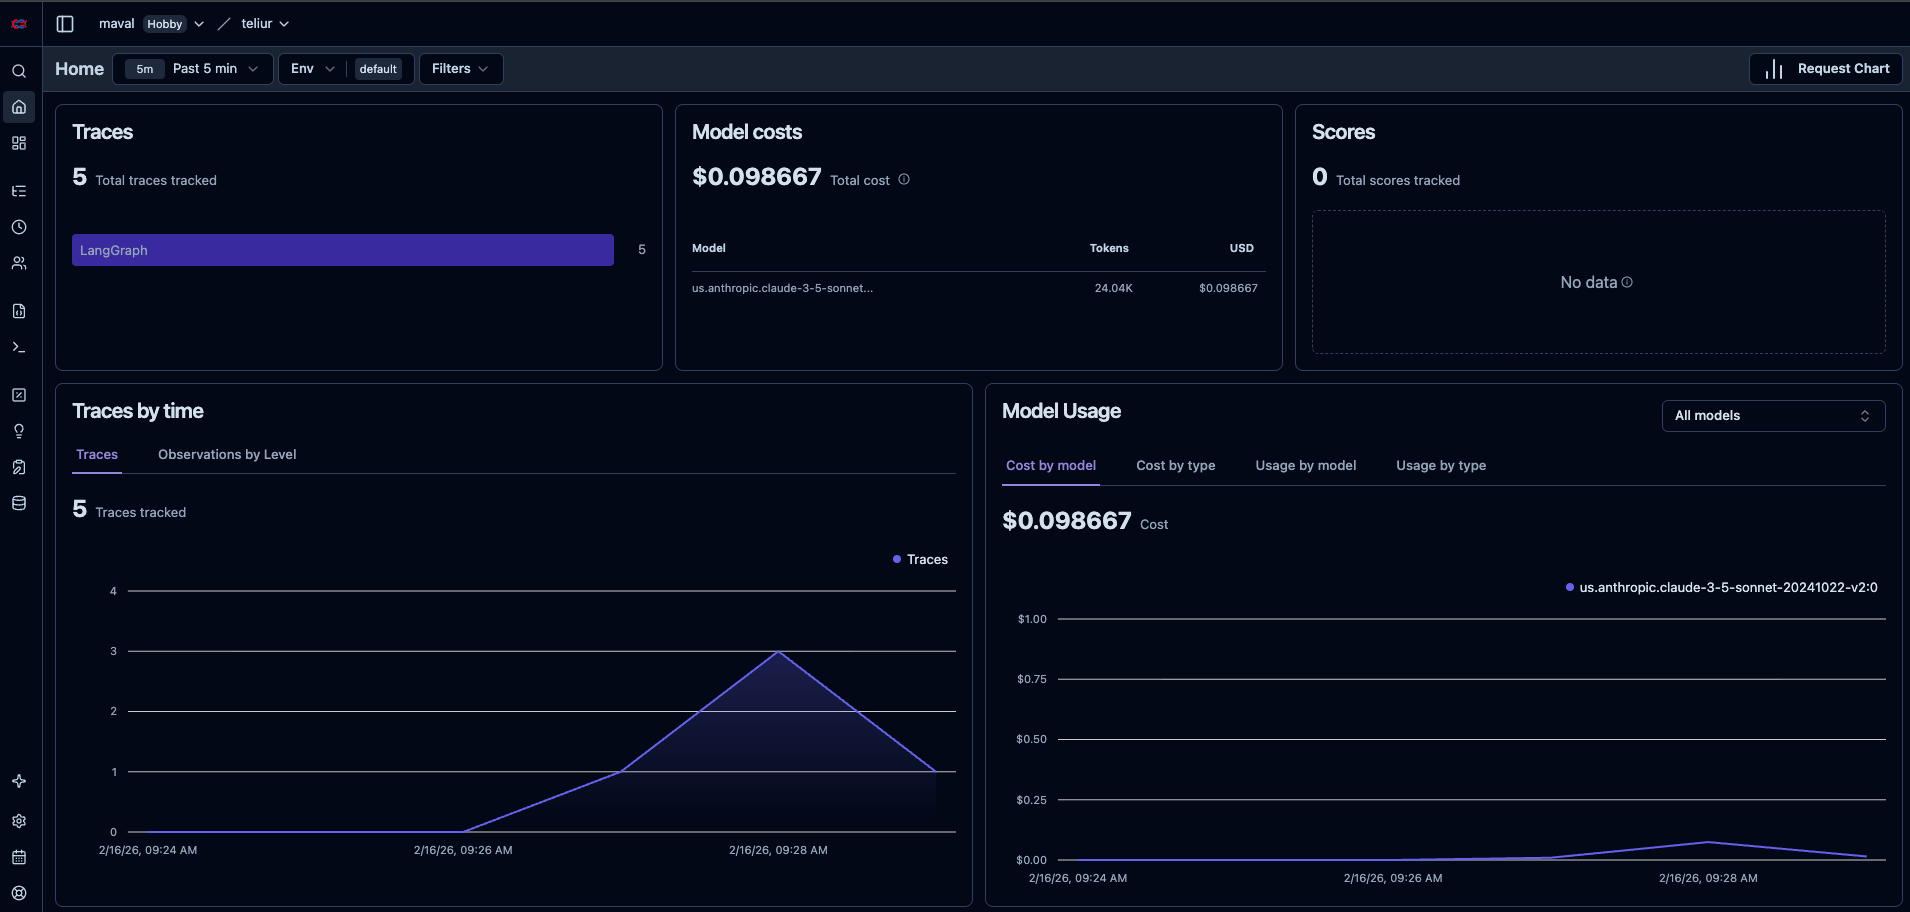

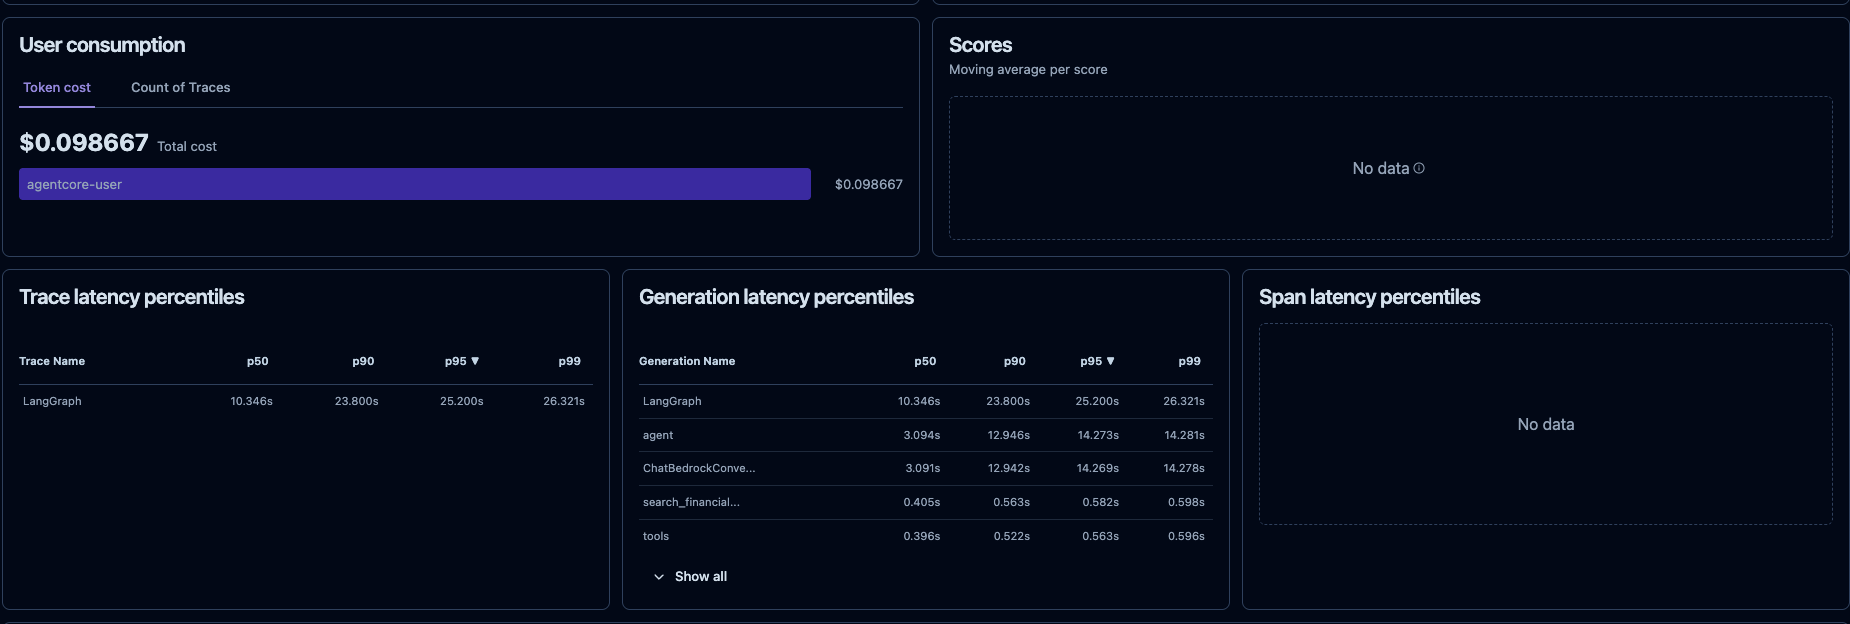

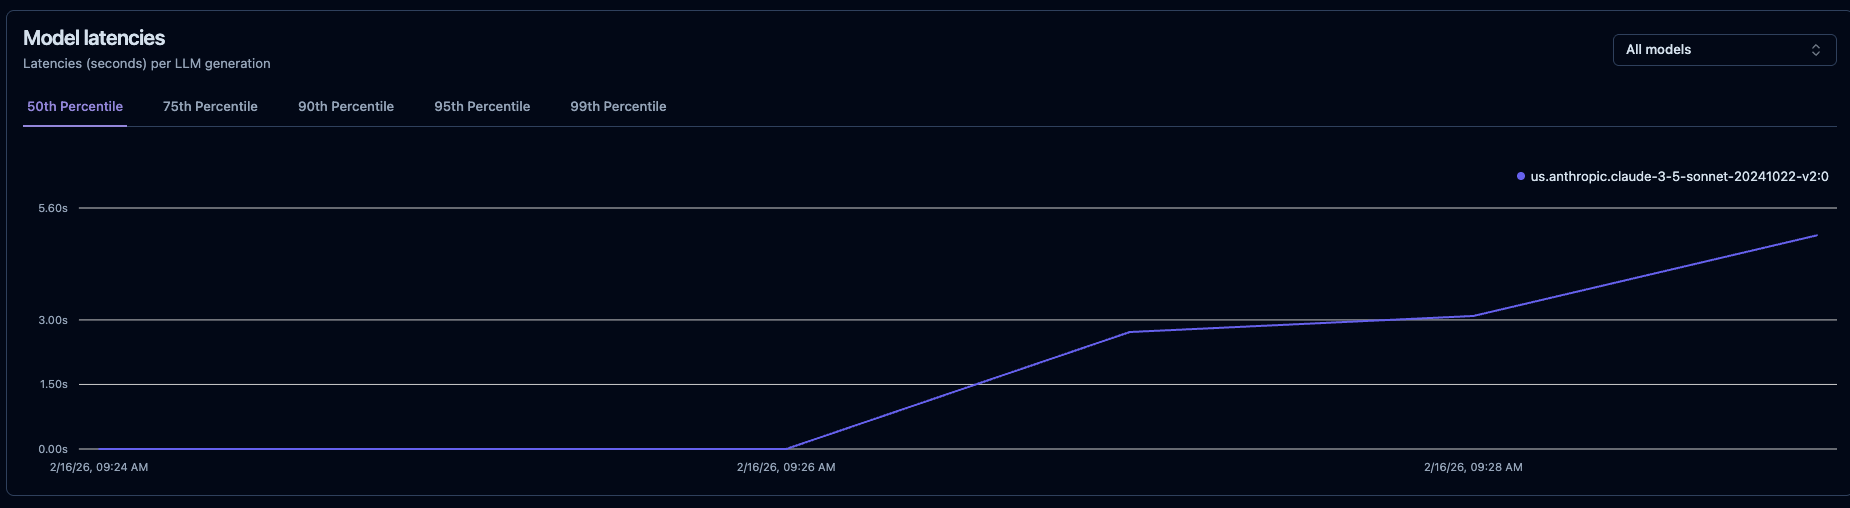